# UMAP - Fashion MNIST

## Importaciones

In [13]:
import pandas as pd
import matplotlib
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gdown
import numpy as np
import struct
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import umap


## Funciones de Carga de Datos

In [14]:
def download_data(file_id, name_file):
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, name_file, quiet=False)
    return name_file


def read_labels(file_path):
    class_names = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot",
    }

    with open(file_path, "rb") as f:
        magic, num_labels = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    df = pd.DataFrame(labels, columns=["label"])
    df["class_name"] = df["label"].map(class_names)
    return df


def extrar_feature_images(file_path):
    with open(file_path, "rb") as f:
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        print("Número de imágenes:", num_images)
        print("Dimensiones de cada imagen:", rows, "x", cols)
        image_data = np.frombuffer(f.read(), dtype=np.uint8)
        images = image_data.reshape(num_images, rows, cols)
        X = images.reshape(num_images, rows * cols)
        print("Forma de la matriz final:", X.shape)
    return X


## Funciones de Visualización

In [15]:
def Show_Image(X, nro_imagen):
    if nro_imagen < 0 or nro_imagen >= X.shape[0]:
        raise IndexError(
            f"El índice {nro_imagen} está fuera de rango. Debe estar entre 0 y {X.shape[0]-1}"
        )

    img = X[nro_imagen].reshape(28, 28)
    plt.imshow(img, cmap="gray")
    plt.title(f"Imagen #{nro_imagen}")
    plt.axis("off")
    plt.show()


def visualizar_reduccion_2d(X_reduced, y, metodo_nombre, class_names_dict):
    plt.figure(figsize=(12, 10))

    for clase in np.unique(y):
        indices = y == clase
        plt.scatter(
            X_reduced[indices, 0],
            X_reduced[indices, 1],
            label=class_names_dict[clase],
            alpha=0.6,
            s=20,
        )

    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.title(f"Visualización 2D - {metodo_nombre}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

## Funciones de Preprocesamiento

In [16]:
def normalize_train(x):
    scaler = MinMaxScaler()
    x_norm = scaler.fit_transform(x)
    return x_norm, scaler


def normalize_test(x, scaler):
    x_norm = scaler.transform(x)
    return x_norm


def addBias(x):
    return np.column_stack([np.ones(x.shape[0]), x])

## Función de UMAP

In [17]:
def umap_embedding(
    X,
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    n_jobs=-1,
):
    mapper = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        n_jobs=n_jobs,
    )
    X_embedded = mapper.fit_transform(X)
    return mapper, X_embedded

## Funciones de Evaluación

In [18]:
def generar_matriz_confusion(
    y_true, y_pred, modelo_nombre, class_names=None
):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap="Blues", values_format=".2f")
    plt.title(f"Matriz de Confusión - {modelo_nombre}")
    plt.tight_layout()
    plt.show()

    return cm


def evaluar_modelos(
    X_train, y_train, X_test, y_test, mostrar_matrices=True, save_dir="resultados"
):
    modelos = {
        "SVM": SVC(kernel="rbf", class_weight="balanced", random_state=42),
        "Logistic Regression": LogisticRegression(
            max_iter=2000, solver="saga", class_weight="balanced", random_state=42
        ),
        "Random Forest": RandomForestClassifier(
            n_estimators=200, class_weight="balanced", random_state=42
        ),
        "KNN": KNeighborsClassifier(n_neighbors=5),
    }

    class_names = [
        "T-shirt",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ]

    if mostrar_matrices:
        os.makedirs(save_dir, exist_ok=True)

    resultados = []

    for nombre, modelo in modelos.items():
        print(f"\nEntrenando {nombre}...")
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        resultados.append(
            {
                "Modelo": nombre,
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(
                    y_test, y_pred, average="weighted", zero_division=0
                ),
                "Recall": recall_score(
                    y_test, y_pred, average="weighted", zero_division=0
                ),
                "F1-Score": f1_score(
                    y_test, y_pred, average="weighted", zero_division=0
                ),
            }
        )

        if mostrar_matrices:
            generar_matriz_confusion(y_test, y_pred, nombre, class_names)

    return pd.DataFrame(resultados)

## Cargar Datos

In [19]:
# Descargando la data solo la primera vez
file_train_X = download_data("1enziBIpqiv_t95KQcifsclNH2BdR8lAd","train_X")
file_test_X = download_data("1Jeax6tnQ6Nmr2PTNXdQqzKnN0YqtrLe4","test_X")
file_train_Y = download_data("1MZtn2iA5cgiYT1i3O0ECuR01oD0kGHh7","train_Y")
file_test_Y = download_data("1K5pxwk2s3RDYsYuwv8RftJTXZ-RGR7K4","test_Y")

Downloading...
From: https://drive.google.com/uc?id=1enziBIpqiv_t95KQcifsclNH2BdR8lAd
To: /content/train_X
100%|██████████| 47.0M/47.0M [00:00<00:00, 180MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Jeax6tnQ6Nmr2PTNXdQqzKnN0YqtrLe4
To: /content/test_X
100%|██████████| 7.84M/7.84M [00:00<00:00, 96.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MZtn2iA5cgiYT1i3O0ECuR01oD0kGHh7
To: /content/train_Y
100%|██████████| 60.0k/60.0k [00:00<00:00, 34.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1K5pxwk2s3RDYsYuwv8RftJTXZ-RGR7K4
To: /content/test_Y
100%|██████████| 10.0k/10.0k [00:00<00:00, 9.96MB/s]


## Preprocesamiento - Normalización

In [20]:
train_X = extrar_feature_images(file_train_X )
test_X = extrar_feature_images(file_test_X )
train_Y = read_labels(file_train_Y)
test_Y = read_labels(file_test_Y)

train_X_norm, scaler = normalize_train(train_X)
test_X_norm = normalize_test(test_X, scaler)
train_X_norm = addBias(train_X_norm)
test_X_norm = addBias(test_X_norm)

Número de imágenes: 60000
Dimensiones de cada imagen: 28 x 28
Forma de la matriz final: (60000, 784)
Número de imágenes: 10000
Dimensiones de cada imagen: 28 x 28
Forma de la matriz final: (10000, 784)


## UMAP 2D

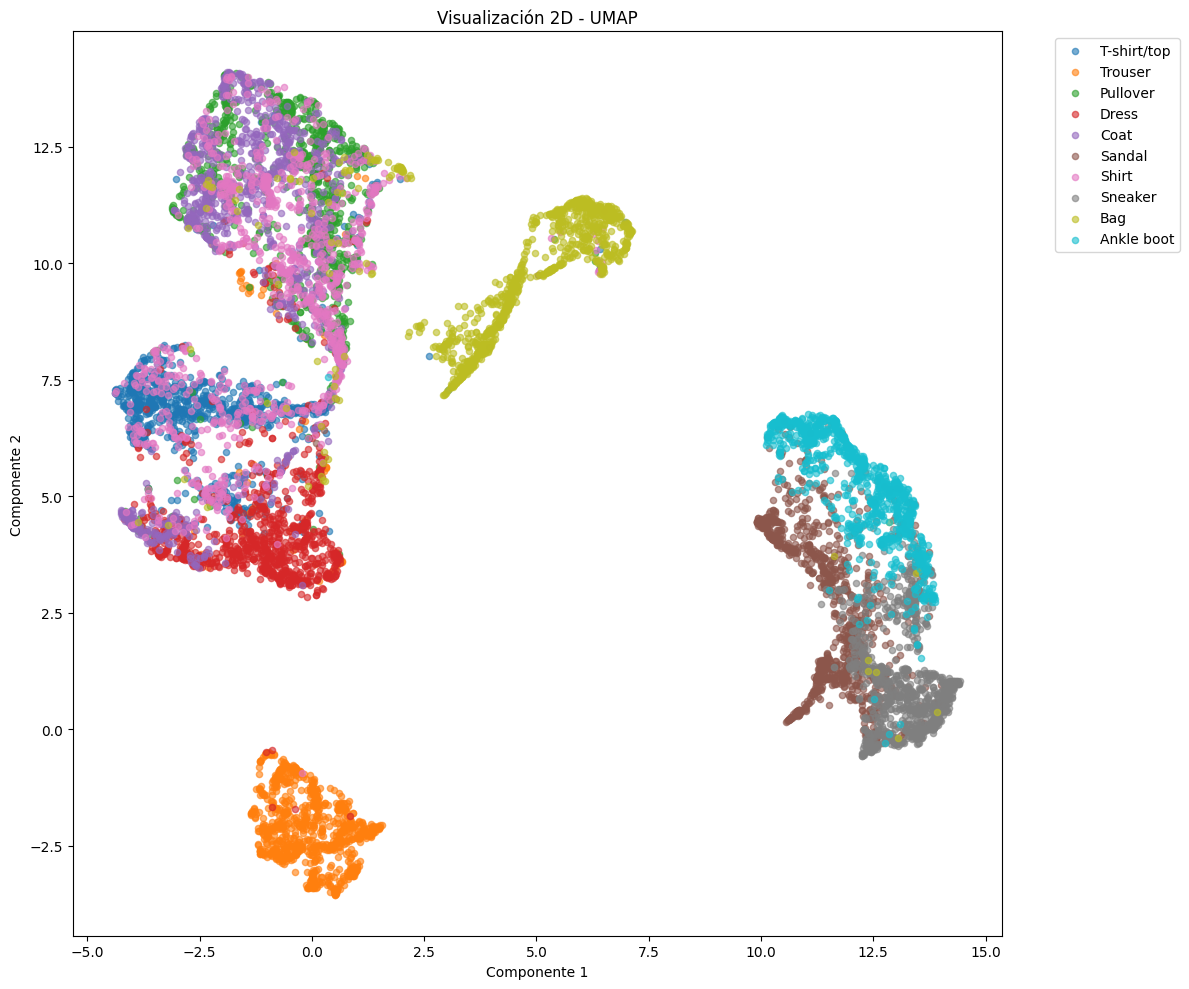

In [21]:
class_names_dict = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

n_viz = min(10000, len(train_X_norm))
viz_indices = np.random.choice(len(train_X_norm), n_viz, replace=False)
X_viz = train_X_norm[viz_indices]
y_viz = train_Y["label"].values[viz_indices]


mapper_2d, X_umap_2d = umap_embedding(
    X_viz,
    n_components=2,
    n_neighbors=10,
    min_dist=0.1,
    metric='euclidean',
    n_jobs=-1
)

visualizar_reduccion_2d(
    X_umap_2d,
    y_viz,
    "UMAP",
    class_names_dict,
)

## Implementacion de UMAP


In [22]:
n_components_clf = 100
n_train_samples = min(60000, len(train_X_norm))

mapper_clf, train_X_umap = umap_embedding(
    train_X_norm,
    n_components=n_components_clf,
    n_neighbors=10,
    min_dist=0.1,
    metric='euclidean',
    n_jobs=-1
)

**bold text** Transformar Datos de Test

In [23]:
test_X_umap = mapper_clf.transform(test_X_norm)

## Entrenamiento y Evaluación de Modelos


Entrenando SVM...


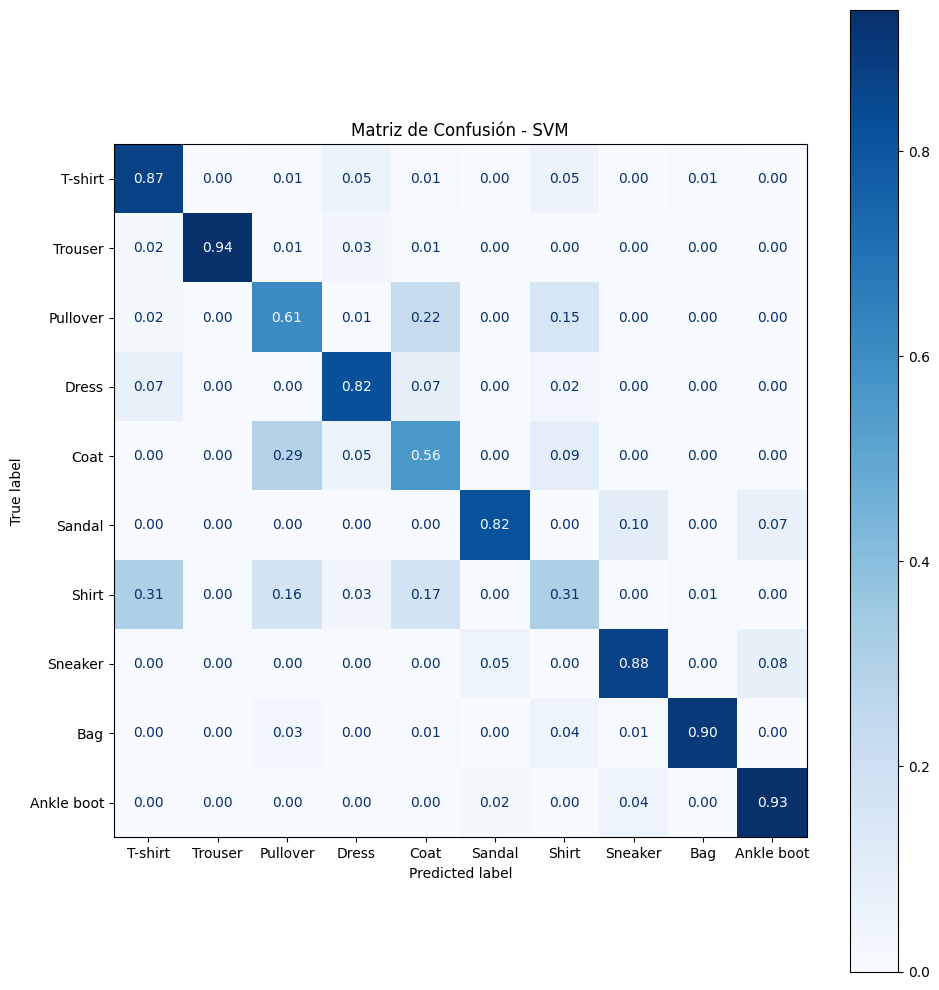


Entrenando Logistic Regression...


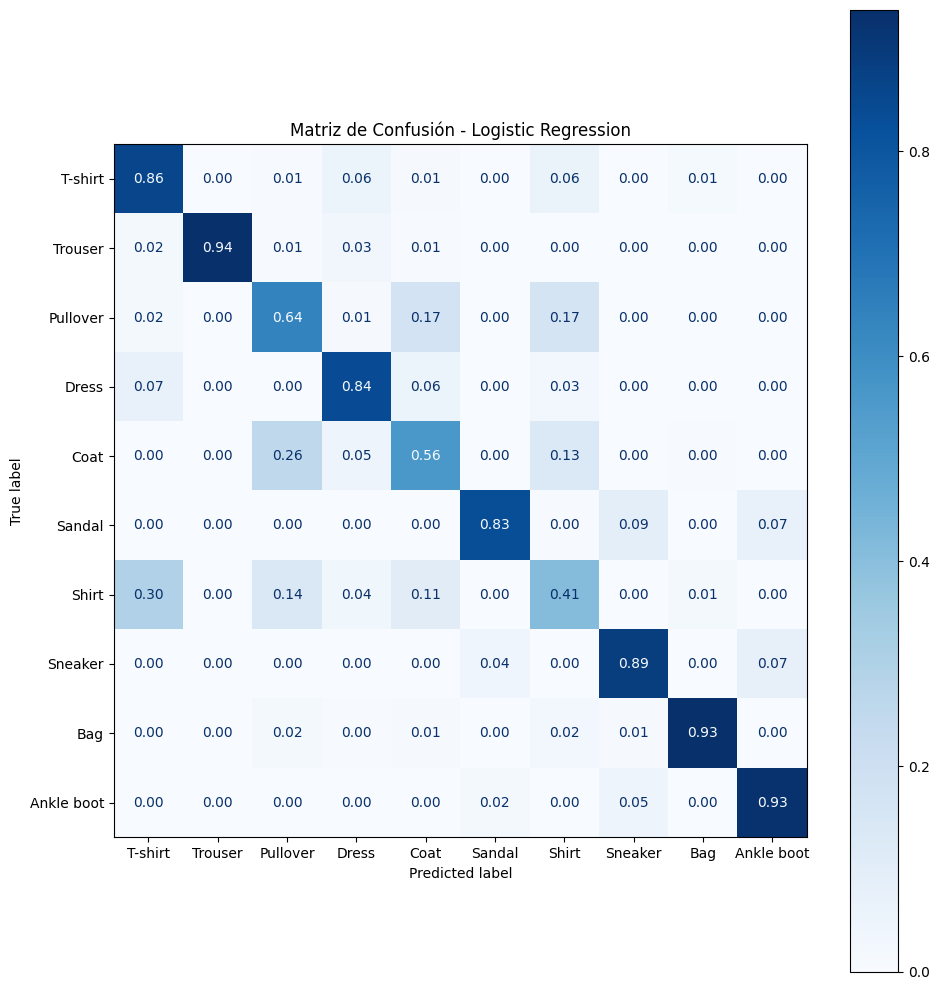


Entrenando Random Forest...


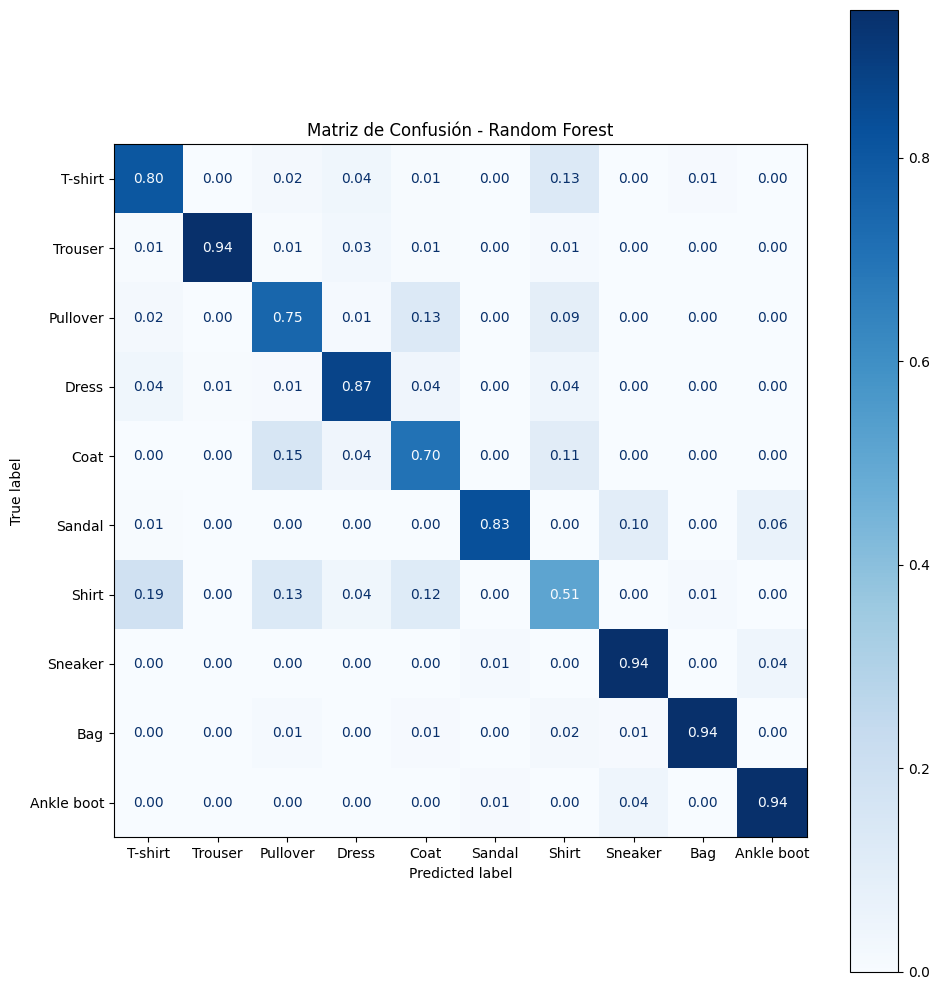


Entrenando KNN...


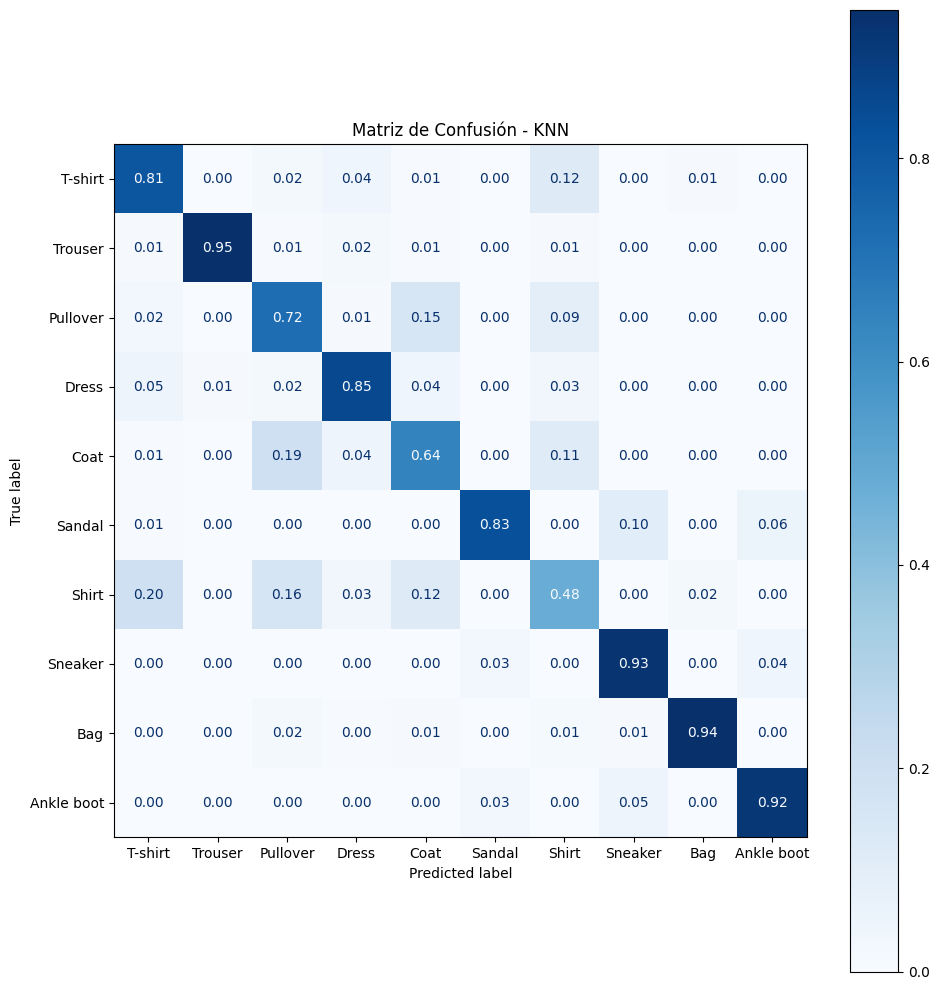

             Modelo  Accuracy  Precision  Recall  F1-Score
                SVM    0.7635   0.763187  0.7635  0.759856
Logistic Regression    0.7821   0.781898  0.7821  0.779817
      Random Forest    0.8242   0.825840  0.8242  0.823853
                KNN    0.8065   0.807068  0.8065  0.805522


In [24]:
resultados_umap = evaluar_modelos(
    train_X_umap,
    train_Y["label"].values,
    test_X_umap,
    test_Y["label"].values,
    mostrar_matrices=True,
    save_dir="resultados_umap",
)

print(resultados_umap.to_string(index=False))